In [1]:
%load_ext tensorboard
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime


#name of model or experiment
model_name = "CNOT_Model"
log_dir= model_name + "/runs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq='batch',
    profile_batch=1,
    embeddings_freq=1,
    embeddings_metadata=None
)

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_batches = 128     # Size of the batches

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()


tf.config.get_visible_devices()


n_qubits = 4

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

dev = qml.device("default.qubit.tf", wires=n_qubits)


2024-08-10 18:39:52.800773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 18:39:53.525970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-10 18:39:54.186737: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-08-10 18:39:54.186771: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-08-10 18:39:54.192159: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-08-10 18:39:54.369240: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-10 18:39:54.3692

In [2]:
keras.utils.get_custom_objects().clear()

@keras.utils.register_keras_serializable(package=(model_name+"_Layer"))
class ConvQLayer(keras.layers.Layer):
    

    #replace the contents of qnode with experiment circuit
    @qml.qnode(dev, interface='tf')
    def q_node(inputs):
        inputs *= np.pi


        # Encoding of 4 classical input values

        for j in range(n_qubits):
            qml.RY(inputs[j], wires=j)

        #Further testing of the AngleEmbedding function is needed
        #qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        # Filter from arxiv.org/abs/2308.14930

        qml.CNOT(wires=[0, 3])
        qml.CNOT(wires=[2, 1])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    def call(self, inputs):

        #14x14 flattened 2x2 squares
        get_subsections_14x14 = lambda im : tf.reshape(tf.unstack(tf.reshape(im,[14,2,14,2]), axis = 2),[14,14,4])
        '''
        example of sequential flat 28x28 indexes after above shuffle
        [
            [
                [  0,   1,  28,  29],
                [ 56,  57,  84,  85],
                ...
                [672, 673, 700, 701],
                [728, 729, 756, 757]
            ],
            [
                [  2,   3,  30,  31],
                ...
                [730, 731, 758, 759]
            ],
            ...
            [
                [ 26,  27,  54,  55],
                ...
                [754, 755, 782, 783]
            ]
        '''

        #unpack 14x14 row by row
        list_squares_2x2 = lambda image_subsections: tf.reshape(tf.unstack(image_subsections, axis = 1), [196,4])


        #send 4 values to quantum function
        process_square_2x2 = lambda square_2x2 : self.q_node(square_2x2)

        #send all squares to the quantum function wrapper
        process_subsections = lambda squares: tf.vectorized_map(process_square_2x2,squares)

        #recompile the larger square
        separate_channels = lambda channel_stack: tf.reshape(channel_stack, [14,14,4])
        #each smaller square (channel) can be extracted as [:, :, channel]
        
        #apply function across batch
        preprocessing = lambda input: tf.vectorized_map(
            lambda image:(separate_channels(tf.transpose(process_subsections(list_squares_2x2(get_subsections_14x14(image)))))),
            input
        )

        return preprocessing(inputs)

qlayer = ConvQLayer()

qlayer.trainable = False

In [3]:
#wrap preprocessing in model

@keras.utils.register_keras_serializable(package=(model_name+"_Pre_Model"))
def Pre_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Rescaling(scale=1./255.0),
        qlayer,
        keras.layers.Rescaling(scale=127.5, offset=127.5)
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
pre_model = Pre_Model()

In [4]:
#core model

@keras.utils.register_keras_serializable(package=(model_name+"_Core_Model"))
def Q_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Rescaling(scale=1./127.5, offset=-1),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

q_model = Q_Model()

#preprocessing
pre_train_images = pre_model.predict(train_images,batch_size=n_batches)
pre_test_images = pre_model.predict(test_images,batch_size=n_batches)

#training
q_history = q_model.fit(
    pre_train_images[:,:,:,[0,1,3]],
    train_labels,
    validation_data=(pre_test_images[:,:,:,[0,1,3]], test_labels),
    batch_size = n_batches,
    epochs=n_epochs,
    verbose=2, callbacks=[tensorboard_callback]
)


469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Epoch 1/30


2024-08-10 18:40:06.034261: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-08-10 18:40:06.034305: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-08-10 18:40:06.444503: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-08-10 18:40:06.446522: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-08-10 18:40:06.446849: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: CNOT_Model/runs/20240810-183954/plugins/profile/2024_08_10_18_40_06/1ba22281c77a.xplane.pb


469/469 - 2s - 5ms/step - accuracy: 0.8045 - loss: 0.7118 - val_accuracy: 0.9025 - val_loss: 0.3576
Epoch 2/30
469/469 - 2s - 4ms/step - accuracy: 0.9107 - loss: 0.3198 - val_accuracy: 0.9245 - val_loss: 0.2694
Epoch 3/30
469/469 - 2s - 4ms/step - accuracy: 0.9256 - loss: 0.2606 - val_accuracy: 0.9333 - val_loss: 0.2344
Epoch 4/30
469/469 - 2s - 4ms/step - accuracy: 0.9330 - loss: 0.2314 - val_accuracy: 0.9369 - val_loss: 0.2152
Epoch 5/30
469/469 - 2s - 4ms/step - accuracy: 0.9380 - loss: 0.2134 - val_accuracy: 0.9397 - val_loss: 0.2030
Epoch 6/30
469/469 - 2s - 4ms/step - accuracy: 0.9413 - loss: 0.2011 - val_accuracy: 0.9414 - val_loss: 0.1945
Epoch 7/30
469/469 - 2s - 4ms/step - accuracy: 0.9434 - loss: 0.1921 - val_accuracy: 0.9432 - val_loss: 0.1883
Epoch 8/30
469/469 - 2s - 4ms/step - accuracy: 0.9455 - loss: 0.1851 - val_accuracy: 0.9443 - val_loss: 0.1836
Epoch 9/30
469/469 - 2s - 4ms/step - accuracy: 0.9471 - loss: 0.1796 - val_accuracy: 0.9449 - val_loss: 0.1799
Epoch 10/30


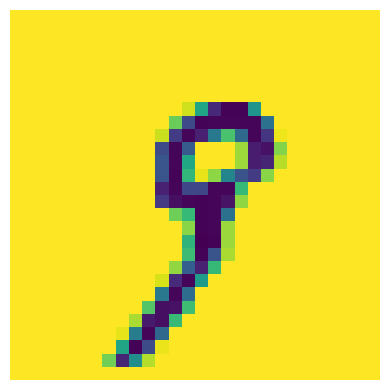

In [5]:

sample = np.asarray(train_images[19,:,:]).copy()

#sample[:,:,[1,2]] = np.NAN

compdiffs = (-1 * sample)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

ax.imshow(compdiffs)
ax.axis('off')


plt.tight_layout()
plt.show()

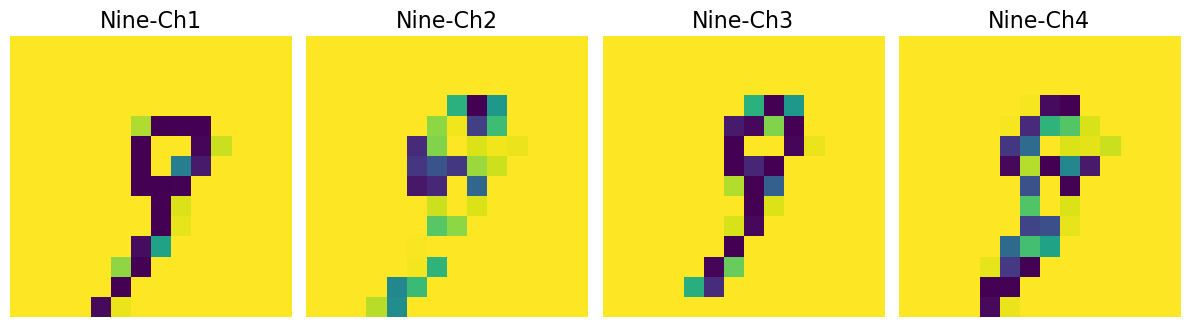

In [6]:
#example of quantum preprocessed(filtered) chanels
image_titles = ['Nine-Ch1', 'Nine-Ch2', 'Nine-Ch3','Nine-Ch4']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(pre_train_images[19][:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()


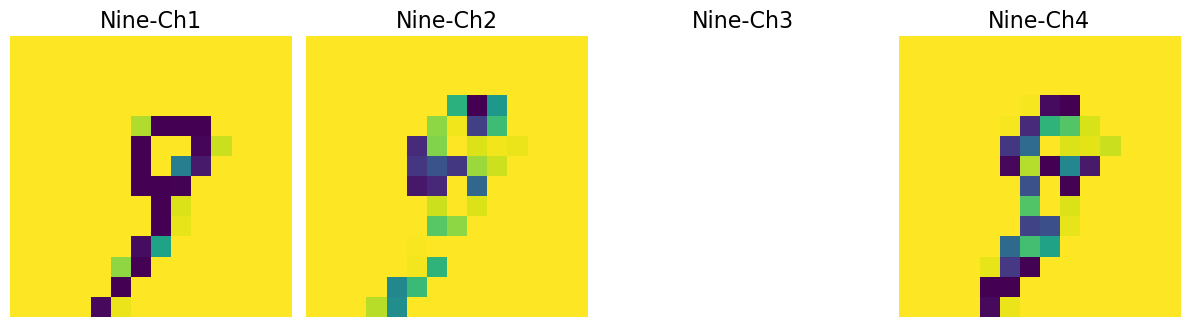

In [7]:
sample = np.asarray(pre_train_images[19]).copy()

sample[:,:,[2]] = np.NAN

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(sample[:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

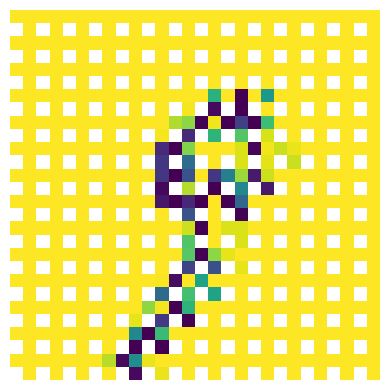

In [8]:


reassembled_pt1 = lambda square: tf.reshape(tf.vectorized_map(lambda inp: tf.transpose(inp),tf.transpose(square)),[2,14,2,14])

reassembled = lambda square: tf.reshape(tf.stack(tf.reshape(tf.stack(reassembled_pt1(square),axis=2),[2,28*14]),axis=1),[28,28])

compdiffs = reassembled(sample[:,:,[0,1,2,3]])

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.imshow(compdiffs)
ax.axis('off')


plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00015175015..1.0000001].


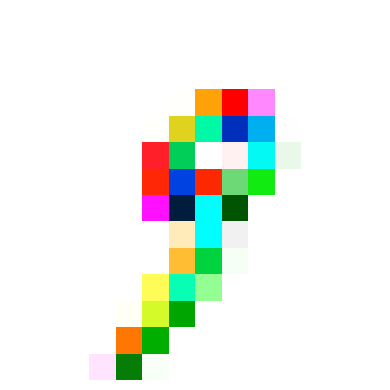

In [18]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.imshow((sample[:,:,[0,1,3]]/(255)))
ax.axis('off')


plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.99984825].


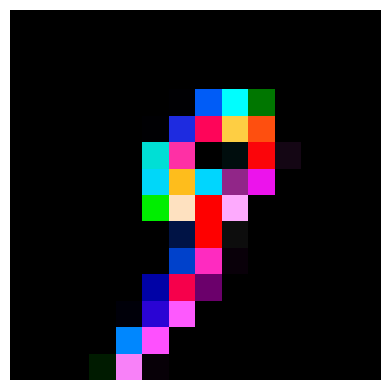

In [17]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.imshow((sample[:,:,[0,1,3]]/(-255))+1.0)
ax.axis('off')


plt.tight_layout()
plt.show()